Running Adversarial Neuron Pruning

In [1]:
import torch
import torchvision

from torchsummary import summary

import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load dataset

In [4]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
cifar10_train = torchvision.datasets.CIFAR10('datasets/cifar_10', download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10('datasets/cifar_10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### modify dataset

In [6]:
# we use 0.9 of the whole dataset as the poisoned set
poisoned_set_ratio = 0.9

In [7]:
dataset_images = np.array([c[0] for c in cifar10_train])
dataset_labels = np.array([c[1] for c in cifar10_train])

In [8]:
# create a subset of the dataset
l = len(cifar10_train)
indices = np.arange(l)

In [9]:
np.random.seed(594462)
np.random.shuffle(indices)

# since we use 0.9 of the set as backdoored training set, we will use the rest 0.1 as fixing set
keep_indices = indices[int(l * poisoned_set_ratio):]

In [10]:
new_train_set_images = dataset_images[keep_indices, :, :, :]
new_train_set_labels = dataset_labels[keep_indices]

In [11]:
# create a new training set
new_train_set = torch.utils.data.TensorDataset(torch.tensor(new_train_set_images), torch.tensor(new_train_set_labels))

In [12]:
train_loader = torch.utils.data.DataLoader(new_train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=200, shuffle=False, num_workers=4)

### Create and load the ResNet18

In [13]:
num_classes = 10

In [14]:
res18 = torchvision.models.resnet18().cuda() if torch.cuda.is_available() else torchvision.models.resnet18()
res18.fc = torch.nn.Linear(res18.fc.in_features, num_classes).cuda() if torch.cuda.is_available() else torch.nn.Linear(res18.fc.in_features, num_classes)

In [15]:
# check if the parameters are in cuda
next(res18.parameters()).is_cuda

True

In [16]:
res18.load_state_dict(torch.load(f'saved_models/ResNet18-CIFAR10-backdoored-5-Epoch-200.pth'))

C:\Users\Kevvol\AppData\Local\Temp\ipykernel_21276\3783847679.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res18.load_state_dict(torch.load(f'saved_models/ResNet18-CI

<All keys matched successfully>

### Create ANP wrapper

In [17]:
from ANP import *

In [18]:
from tqdm import tqdm

In [19]:
# anp_system = ANPWrapper(res18, tradeoff=0.1, lr=0.2, ep=0.8)
anp_system = ANPWrapper(res18, tradeoff=0.2, lr=0.2, ep=0.4)

In [20]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(anp_system.weight_masks_optimizer, T_max=200)

In [21]:
# copied from assignment 2
def compute_accuracy(prediction,gt_logits):
    pred_idx = np.argmax(prediction,1,keepdims=True)
    matches = pred_idx == gt_logits[:,None]
    acc = matches.mean()
    return acc

In [22]:
# add a backdoor to a test set to see its efficacy
def introduce_backdoor_test_set(inputs):
    pxl_w = torch.tensor((1.0, 1.0, 1.0))
    pxl_b = torch.tensor((0.0, 0.0, 0.0))
    # pxl_w = (1.0 - 0.4914) / 0.2023
    # pxl_b = (0.0 - 0.4914) / 0.2023
    all_indices = torch.arange(inputs.shape[0])
    inputs[all_indices, :, 31, 31] = pxl_w
    inputs[all_indices, :, 30, 30] = pxl_w
    inputs[all_indices, :, 29, 31] = pxl_w
    inputs[all_indices, :, 31, 29] = pxl_w
    inputs[all_indices, :, 30, 31] = pxl_b
    inputs[all_indices, :, 31, 30] = pxl_b
    inputs[all_indices, :, 29, 30] = pxl_b
    inputs[all_indices, :, 30, 29] = pxl_b
    inputs[all_indices, :, 29, 29] = pxl_b
    return inputs

In [23]:
# grab the gradients of the weights
# we need to see if the suspicion of gradient values carrying over is true
def get_weight_grads(model):
    grads = []
    for name, param in model.named_parameters():
        if name.endswith('weight'):
            grads.append(torch.abs(param.grad).sum().item())
    return grads

In [24]:
test_acc_list = []
asr_list = []

grads_magnitudes = []

# train for this many epochs
for epoch in tqdm(range(50)):
    anp_system.model.train()
    
    i = 0
    total_weight_masks_loss = 0
    for inputs, label in train_loader:
        inputs, label = inputs.to(device), label.to(device)
        # perform perturb step
        weight_masks_loss = anp_system.perturb_step(inputs, label)
        total_weight_masks_loss += weight_masks_loss
        # print(f'epoch: {epoch} | iteration: {i} | weight_mask_loss: {weight_masks_loss}')
        i += 1
    print(f'epoch: {epoch} | total_weight_masks_loss: {total_weight_masks_loss}')

    # record gradient magnitudes
    # grads_magnitudes.append(get_weight_grads(anp_system.model))
    
    # in eval mode, we test backdoor effectiveness
    # anp_system.model.eval()
    
    # # testing loop (normal data)
    # total_test_acc = 0
    # test_item_ct = 0
    # with torch.no_grad():
    #     for inputs, label in test_loader:
    #         inputs, label = inputs.to(device), label.to(device)
            
    #         pred = anp_system.model(inputs)
    #         accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
            
    #         total_test_acc += accuracy * inputs.shape[0]
    #         test_item_ct += inputs.shape[0]
    # print(f'Test Accuracy: {total_test_acc/test_item_ct}')
    # test_acc_list.append(total_test_acc/test_item_ct)
    
    # # test with backdoor inserted to training set images
    # backdoor_success_ct = 0
    # backdoor_item_ct = 0
    # with torch.no_grad():
    #     for inputs, label in test_loader:
    #         inputs = introduce_backdoor_test_set(inputs).to(device)
            
    #         pred = anp_system.model(inputs)
    #         pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

    #         # be careful to remove the test dataset items that originally were label 0
    #         # since we don't want to mix them in with testing backdoor on labels 1-9
    #         backdoor_success_ct += np.sum((pred_lbls == 0).flatten() & (label.numpy() != 0))
    #         # backdoor_item_ct += inputs.shape[0]
    #         backdoor_item_ct += np.sum(label.numpy() != 0)
    
    # print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')
    # asr_list.append(backdoor_success_ct/backdoor_item_ct)

    # scheduler.step()

  2%|█▋                                                                                 | 1/50 [00:06<05:20,  6.55s/it]

epoch: 0 | total_weight_masks_loss: 133.36303704231977


  4%|███▎                                                                               | 2/50 [00:12<04:51,  6.08s/it]

epoch: 1 | total_weight_masks_loss: 103.71352577209473


  6%|████▉                                                                              | 3/50 [00:17<04:32,  5.80s/it]

epoch: 2 | total_weight_masks_loss: 92.41000124812126


  8%|██████▋                                                                            | 4/50 [00:23<04:19,  5.65s/it]

epoch: 3 | total_weight_masks_loss: 90.69144606590271


 10%|████████▎                                                                          | 5/50 [00:28<04:12,  5.60s/it]

epoch: 4 | total_weight_masks_loss: 85.4173434972763


 12%|█████████▉                                                                         | 6/50 [00:34<04:04,  5.55s/it]

epoch: 5 | total_weight_masks_loss: 89.5700943917036


 14%|███████████▌                                                                       | 7/50 [00:39<03:58,  5.55s/it]

epoch: 6 | total_weight_masks_loss: 88.4493472725153


 16%|█████████████▎                                                                     | 8/50 [00:45<03:51,  5.52s/it]

epoch: 7 | total_weight_masks_loss: 87.61247120797634


 18%|██████████████▉                                                                    | 9/50 [00:50<03:45,  5.49s/it]

epoch: 8 | total_weight_masks_loss: 85.92882184684277


 20%|████████████████▍                                                                 | 10/50 [00:56<03:41,  5.55s/it]

epoch: 9 | total_weight_masks_loss: 85.37820189446211


 22%|██████████████████                                                                | 11/50 [01:01<03:35,  5.54s/it]

epoch: 10 | total_weight_masks_loss: 85.43754780292511


 24%|███████████████████▋                                                              | 12/50 [01:08<03:38,  5.76s/it]

epoch: 11 | total_weight_masks_loss: 85.06670087575912


 26%|█████████████████████▎                                                            | 13/50 [01:14<03:38,  5.90s/it]

epoch: 12 | total_weight_masks_loss: 82.41983801871538


 28%|██████████████████████▉                                                           | 14/50 [01:20<03:31,  5.87s/it]

epoch: 13 | total_weight_masks_loss: 85.87028180062771


 30%|████████████████████████▌                                                         | 15/50 [01:25<03:24,  5.83s/it]

epoch: 14 | total_weight_masks_loss: 83.9657638669014


 32%|██████████████████████████▏                                                       | 16/50 [01:31<03:17,  5.80s/it]

epoch: 15 | total_weight_masks_loss: 85.1598210260272


 34%|███████████████████████████▉                                                      | 17/50 [01:37<03:10,  5.77s/it]

epoch: 16 | total_weight_masks_loss: 85.41025434434414


 36%|█████████████████████████████▌                                                    | 18/50 [01:42<03:02,  5.69s/it]

epoch: 17 | total_weight_masks_loss: 86.79407979547977


 38%|███████████████████████████████▏                                                  | 19/50 [01:48<02:58,  5.77s/it]

epoch: 18 | total_weight_masks_loss: 85.3423959761858


 40%|████████████████████████████████▊                                                 | 20/50 [01:54<02:53,  5.79s/it]

epoch: 19 | total_weight_masks_loss: 86.37959156930447


 42%|██████████████████████████████████▍                                               | 21/50 [02:00<02:48,  5.80s/it]

epoch: 20 | total_weight_masks_loss: 84.99279974400997


 44%|████████████████████████████████████                                              | 22/50 [02:06<02:41,  5.78s/it]

epoch: 21 | total_weight_masks_loss: 83.08871418237686


 46%|█████████████████████████████████████▋                                            | 23/50 [02:11<02:35,  5.77s/it]

epoch: 22 | total_weight_masks_loss: 86.04238571226597


 48%|███████████████████████████████████████▎                                          | 24/50 [02:17<02:29,  5.75s/it]

epoch: 23 | total_weight_masks_loss: 85.77519170939922


 50%|█████████████████████████████████████████                                         | 25/50 [02:23<02:24,  5.80s/it]

epoch: 24 | total_weight_masks_loss: 84.30217398703098


 52%|██████████████████████████████████████████▋                                       | 26/50 [02:29<02:19,  5.81s/it]

epoch: 25 | total_weight_masks_loss: 83.64070545136929


 54%|████████████████████████████████████████████▎                                     | 27/50 [02:35<02:14,  5.83s/it]

epoch: 26 | total_weight_masks_loss: 82.0700361430645


 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:41<02:09,  5.89s/it]

epoch: 27 | total_weight_masks_loss: 87.66513635218143


 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:47<02:05,  5.96s/it]

epoch: 28 | total_weight_masks_loss: 85.66932801902294


 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:53<02:00,  6.00s/it]

epoch: 29 | total_weight_masks_loss: 84.38295591622591


 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:59<01:54,  6.04s/it]

epoch: 30 | total_weight_masks_loss: 82.07830730080605


 64%|████████████████████████████████████████████████████▍                             | 32/50 [03:05<01:48,  6.02s/it]

epoch: 31 | total_weight_masks_loss: 83.80367618054152


 66%|██████████████████████████████████████████████████████                            | 33/50 [03:11<01:42,  6.05s/it]

epoch: 32 | total_weight_masks_loss: 85.22760722786188


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [03:17<01:37,  6.11s/it]

epoch: 33 | total_weight_masks_loss: 85.18557980656624


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [03:23<01:29,  6.00s/it]

epoch: 34 | total_weight_masks_loss: 83.88609505444765


 72%|███████████████████████████████████████████████████████████                       | 36/50 [03:29<01:22,  5.92s/it]

epoch: 35 | total_weight_masks_loss: 82.442617431283


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [03:35<01:16,  5.85s/it]

epoch: 36 | total_weight_masks_loss: 83.18791401386261


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:40<01:09,  5.80s/it]

epoch: 37 | total_weight_masks_loss: 81.33225529640913


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:46<01:03,  5.74s/it]

epoch: 38 | total_weight_masks_loss: 85.59792662411928


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [03:51<00:57,  5.71s/it]

epoch: 39 | total_weight_masks_loss: 84.49890594929457


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:57<00:51,  5.68s/it]

epoch: 40 | total_weight_masks_loss: 84.61041441559792


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [04:03<00:45,  5.66s/it]

epoch: 41 | total_weight_masks_loss: 86.32059939205647


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [04:08<00:39,  5.63s/it]

epoch: 42 | total_weight_masks_loss: 84.27318198978901


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [04:14<00:33,  5.62s/it]

epoch: 43 | total_weight_masks_loss: 84.05095708370209


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [04:19<00:28,  5.61s/it]

epoch: 44 | total_weight_masks_loss: 82.54146936535835


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [04:25<00:22,  5.61s/it]

epoch: 45 | total_weight_masks_loss: 83.70817874372005


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [04:31<00:16,  5.61s/it]

epoch: 46 | total_weight_masks_loss: 83.99223284423351


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [04:36<00:11,  5.60s/it]

epoch: 47 | total_weight_masks_loss: 86.33805806189775


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [04:42<00:05,  5.60s/it]

epoch: 48 | total_weight_masks_loss: 83.86112716794014


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:47<00:00,  5.76s/it]

epoch: 49 | total_weight_masks_loss: 85.09258928894997


In [25]:
# grads_magnitudes = np.array(grads_magnitudes)

In [26]:
# raise Exception("stop here first")

In [27]:
# grads_magnitudes.shape

In [28]:
# np.sum((grads_magnitudes[1:, :] - grads_magnitudes[:-1, :]) >= 0, axis=0)

### Consolidate the network by applying the pruning

In [29]:
# remove the hooks
anp_system._remove_hooks()

In [30]:
threshold_values = np.linspace(0.05, 0.95, 19)

In [31]:
threshold_values

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [32]:
# then test the network once more
# with the rigidly pruned neurons

def test_backdoor_success(model):
    backdoor_success_ct = 0
    backdoor_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = introduce_backdoor_test_set(inputs).to(device)
            
            pred = model(inputs)
            pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

            # be careful to remove the test dataset items that originally were label 0
            # since we don't want to mix them in with testing backdoor on labels 1-9
            backdoor_success_ct += np.sum((pred_lbls == 0).flatten() & (label.numpy() != 0))
            # backdoor_item_ct += inputs.shape[0]
            backdoor_item_ct += np.sum(label.numpy() != 0)
    
    # print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')
    return backdoor_success_ct/backdoor_item_ct

In [33]:
# then test the model's accuracy on clean data

def test_clean_acc(model):
    total_test_acc = 0
    test_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            
            pred = model(inputs)
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
            
            total_test_acc += accuracy * inputs.shape[0]
            test_item_ct += inputs.shape[0]
    # print(f'Test Accuracy: {total_test_acc/test_item_ct}')
    return total_test_acc/test_item_ct

In [34]:
asr_list = []
acc_list = []

# apply pruning with progressive threshold to see how its ASR and ACC changes
for threshold_value in threshold_values:
    anp_system._prune_neurons(threshold_value)
    anp_system.model.eval()

    asr = test_backdoor_success(anp_system.model)
    acc = test_clean_acc(anp_system.model)

    print(f'Threshold value: {threshold_value} | ASR: {asr} | ACC: {acc}')

    asr_list.append(asr)
    acc_list.append(acc)

Threshold value: 0.05 | ASR: 1.0 | ACC: 0.7619
Threshold value: 0.1 | ASR: 1.0 | ACC: 0.7589
Threshold value: 0.15 | ASR: 1.0 | ACC: 0.7595
Threshold value: 0.2 | ASR: 1.0 | ACC: 0.7655
Threshold value: 0.25 | ASR: 1.0 | ACC: 0.7651
Threshold value: 0.3 | ASR: 1.0 | ACC: 0.7676
Threshold value: 0.35 | ASR: 1.0 | ACC: 0.7249
Threshold value: 0.39999999999999997 | ASR: 1.0 | ACC: 0.726
Threshold value: 0.44999999999999996 | ASR: 0.09033333333333333 | ACC: 0.7272
Threshold value: 0.49999999999999994 | ASR: 0.0035555555555555557 | ACC: 0.6624
Threshold value: 0.5499999999999999 | ASR: 0.03788888888888889 | ACC: 0.6021
Threshold value: 0.6 | ASR: 0.034888888888888886 | ACC: 0.5945
Threshold value: 0.65 | ASR: 0.08455555555555555 | ACC: 0.443
Threshold value: 0.7 | ASR: 0.08477777777777777 | ACC: 0.4392
Threshold value: 0.75 | ASR: 0.07944444444444444 | ACC: 0.4351
Threshold value: 0.7999999999999999 | ASR: 0.5977777777777777 | ACC: 0.1945
Threshold value: 0.85 | ASR: 0.7857777777777778 | AC

In [35]:
import matplotlib.pyplot as plt

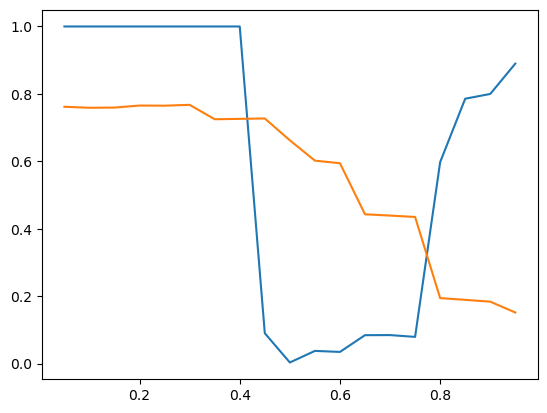

In [36]:
plt.plot(threshold_values, asr_list)
plt.plot(threshold_values, acc_list)

### Below are messy debug pokings

##### weight masks values histogram

In [37]:
all_masks_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_values.append(weight_mask_tensor.cpu().detach().numpy().flatten())

all_masks_values = np.concatenate(all_masks_values)

In [38]:
all_masks_values.shape

(9610,)

Text(0, 0.5, 'Number')

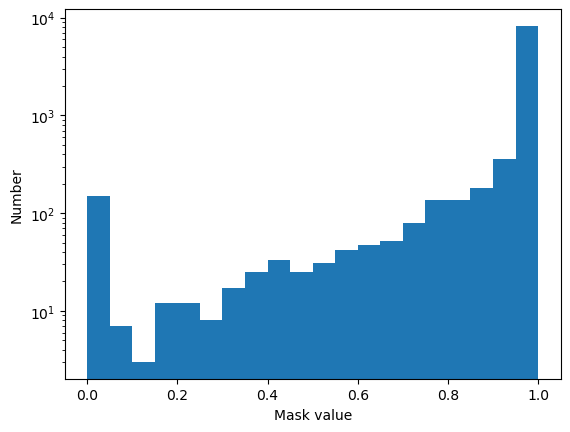

In [39]:
plt.hist(all_masks_values, bins=20, log=True)
plt.xlabel('Mask value')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

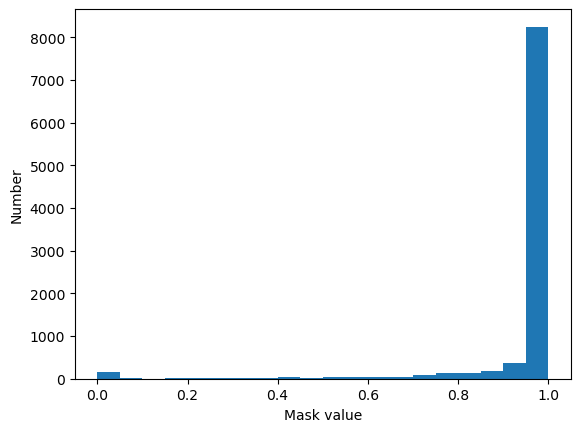

In [40]:
plt.hist(all_masks_values, bins=20)
plt.xlabel('Mask value')
plt.ylabel('Number')

In [41]:
# np.mean(all_masks_values)
np.std(all_masks_values)

np.float32(0.15805432)

In [42]:
all_masks_grad_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_grad_values.append(weight_mask_tensor.grad.cpu().detach().numpy().flatten())

all_masks_grad_values = np.concatenate(all_masks_grad_values)

##### perturbation values histogram

In [43]:
all_perturbations_values = []

for name in anp_system.weight_perturbations:
    weight_perturbation_tensor = anp_system.weight_perturbations[name]
    all_perturbations_values.append(weight_perturbation_tensor.cpu().detach().numpy().flatten())

all_perturbations_values = np.concatenate(all_perturbations_values)

In [44]:
all_perturbations_values.shape

(9610,)

(array([4974.,   53.,   45.,   63.,   67.,   56.,   47.,   60.,   50.,
          74.,   48.,   56.,   62.,   50.,   58.,   55.,   55.,   51.,
          69., 3617.]),
 array([-4.00000006e-01, -3.60000014e-01, -3.19999993e-01, -2.80000001e-01,
        -2.40000010e-01, -2.00000018e-01, -1.60000011e-01, -1.20000005e-01,
        -8.00000131e-02, -4.00000215e-02, -2.98023224e-08,  3.99999917e-02,
         7.99999833e-02,  1.19999975e-01,  1.59999996e-01,  1.99999958e-01,
         2.39999980e-01,  2.80000001e-01,  3.19999963e-01,  3.59999985e-01,
         4.00000006e-01]),
 <BarContainer object of 20 artists>)

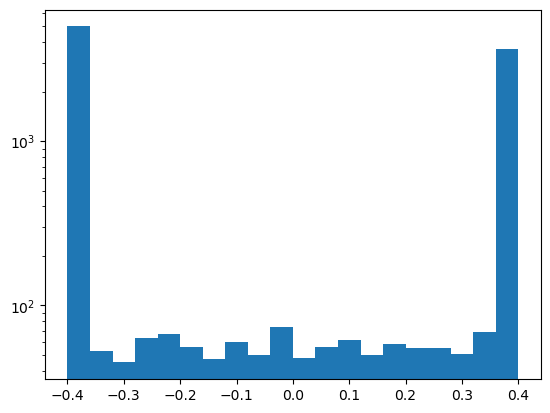

In [45]:
plt.hist(all_perturbations_values, bins=20, log=True)